# I.4 Variational autoencooder

## Preparation

In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
import os
from urllib.request import urlopen
from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
from scipy.stats import norm
import torch

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms
import math

from sklearn.model_selection import ParameterGrid

torch.__version__


'2.6.0+rocm6.2.4'

In [2]:
%load_ext tensorboard


In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda'
else:
    print("No GPU device!")
    device = 'cpu'


GPU: AMD Radeon RX 7800 XT


## Data

In [4]:
class GaussianClustersDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=10000, num_clusters=5, dim=10):
        self.data = []
        self.labels = []

        np.random.seed(42)

        for i in range(num_clusters):
            mean = np.random.uniform(-5, 5, size=(dim,)) # cluster center
            cov = np.eye(dim) * np.random.uniform(0.5, 1.5) # diag cov matrix

            samples = np.random.multivariate_normal(mean, cov, num_samples // num_clusters)

            self.data.append(samples)
            self.labels.extend([i] * (num_samples // num_clusters))

        self.data = np.vstack(self.data).astype(np.float32)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


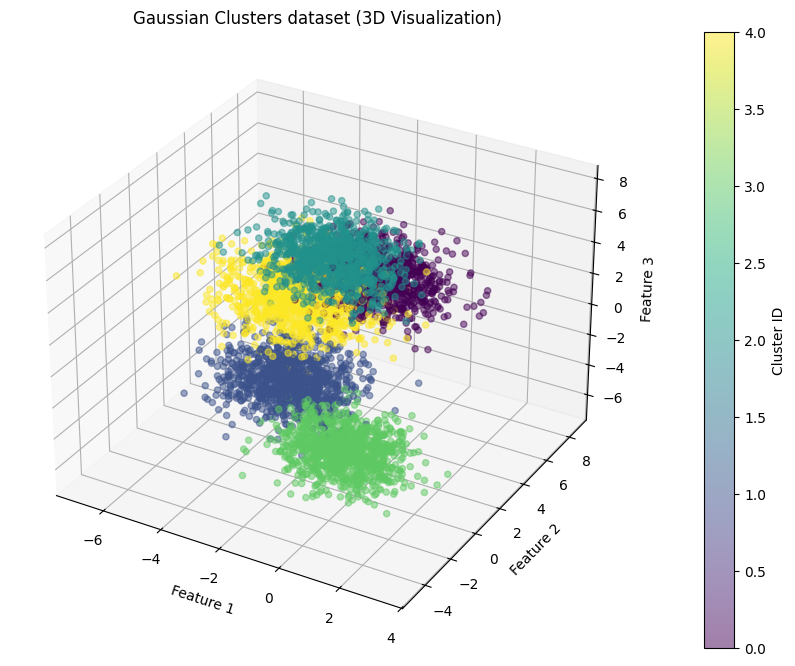

In [5]:
example_dataset = GaussianClustersDataset(num_samples=5000, num_clusters=5, dim=3)
sample_data, sample_labels = example_dataset.data, example_dataset.labels

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(sample_data[:, 0], sample_data[:, 1], sample_data[:, 2], c=sample_labels, cmap='viridis', alpha=0.5)
plt.colorbar(sc, label="Cluster ID")

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.title("Gaussian Clusters dataset (3D Visualization)")

plt.show()


## Training code

### General

In [6]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)

        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)

        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss/total


In [7]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True),
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))

        epoch_loss = train_epoch(train_generator=batch_generator,
                    model=model,
                    loss_function=loss_function,
                    optimizer=optima,
                    callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})


### Specific

In [8]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()

    loss = model.loss(x_batch.to(model.device), y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()


In [9]:
class callback():
    def __init__(self, writer, dataset, loss_function, experiment_name, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.experiment_name = experiment_name
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar(f"{self.experiment_name}/LOSS/train", loss, self.step)

        if self.step % self.delimeter == 0:

            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset,
                                                          batch_size=self.batch_size)

            pred = []
            real = []
            test_loss = 0
            model.eval()
            for it, (x_batch, y_batch) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)
                y_batch = y_batch.to(model.device)

                #output = model(x_batch)
                test_loss += model.loss(x_batch, y_batch)

                #test_loss += self.loss_function(output, x_batch).cpu().item()*len(x_batch)

                #pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())

            test_loss /= len(self.dataset)

            self.writer.add_scalar(f"{self.experiment_name}/LOSS/test", test_loss, self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)


## VAE model

In [11]:
class VAE(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, latent_dim, input_dim, hidden_dim=200, n_layers=2):
        """
        Standart model of VAE with ELBO optimization.
        Args:
            latent_dim: int - the dimension of latent space.
            input_dim: int - the dimension of input space.
            hidden_dim: int - the size of hidden_dim neural layer.
        Returns:
            None
        Example:
            >>> model = VAE(2, 10)
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        hidden_dims = list(np.linspace(self.input_dim, self.hidden_dim, self.n_layers, dtype=int))

        self.encoder_input = torch.nn.Linear(input_dim, hidden_dims[0])
        self.decoder_input = torch.nn.Linear(latent_dim, hidden_dims[-1])

        encoder_modules = []
        decoder_modules = []

        for i in range(len(hidden_dims) - 1):
            encoder_modules.append(
                torch.nn.Sequential(
                    torch.nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    torch.nn.LayerNorm(hidden_dims[i + 1]),
                    torch.nn.LeakyReLU())
            )

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            decoder_modules.append(
                torch.nn.Sequential(
                    torch.nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    torch.nn.LayerNorm(hidden_dims[i + 1]),
                    torch.nn.LeakyReLU())
            )

        final_layer = torch.nn.Sequential(
                        torch.nn.Linear(hidden_dims[-1], hidden_dims[-1]),
                        torch.nn.LayerNorm(hidden_dims[-1]),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dims[-1], 2*input_dim))

        self.proposal_z = torch.nn.Sequential(self.encoder_input, *encoder_modules)

        self.proposal_mu = torch.nn.Linear(self.hidden_dim, self.latent_dim)
        self.proposal_sigma = torch.nn.Linear(self.hidden_dim, self.latent_dim)

        self.generative_network = torch.nn.Sequential(self.decoder_input, *decoder_modules, final_layer)


    def q_z(self, x):
        """
        Generates distribution of z provided x.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
            mu: Tensor - the matrix of shape batch_size x latent_dim.
            sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Example:
            >>>
        """
        x = x.to(self.device)

        proposal = self.proposal_z(x)
        mu = self.proposal_mu(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma(proposal))
        return mu, sigma

    def p_z(self, num_samples):
        """
        Generetes prior distribution of z.
        Args:
            num_samples: int - the number of samples.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape num_samples x latent_dim.
            	sigma: Tensor - the matrix of shape num_samples x latent_dim.
        Example:
            >>>
        """
        mu = torch.zeros([num_samples, self.latent_dim], device=self.device)
        sigma = torch.ones([num_samples, self.latent_dim], device=self.device)
        return mu, sigma

    def sample_z(self, distr, num_samples=1):
        """
        Generates samples from normal distribution q(z|x).
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            num_samples: int - the number of samples for each element.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x latent_dim - samples from normal distribution in latent space.
        Example:
            >>>
        """
        mu, sigma = distr
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        batch_size = mu.shape[0]

        bias = mu.view([batch_size, 1, self.latent_dim])

        epsilon = torch.randn([batch_size, num_samples, self.latent_dim],
                              requires_grad=True,
                              device=self.device)
        scale = sigma.view([batch_size, 1, self.latent_dim])

        return bias + epsilon * scale

    def q_x(self, z):
        """
        Given the latent representation matrix z, returns the parameters of a normal distribution
        (mean and standard deviation) for generating x.

        Args:
            z: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples from latent space.

        Returns:
            Tensor - the tensor of shape batch_size x num_samples x (2 * input_dim),
                    where first half represents mean, second half represents standard deviation.

        """
        z = z.to(self.device)
        out = self.generative_network(z)  # Output of dim input_dim * 2
        mu, sigma = torch.chunk(out, 2, dim=-1)  # Split into 2 parts: avg and dispersion

        sigma = torch.nn.Softplus()(sigma)  # Softplus quarantees sigma > 0
        return torch.cat([mu, sigma], dim=-1)  # Merge


    def loss(self, batch_x, batch_y):
        """
        Calculate ELBO approximation of log likelihood for given batch with negative sign.
        Args:
            batch_x: FloatTensor - the matrix of shape batch_size x input_dim.
            batch_y: FloatTensor - dont uses parameter in this model.
        Returns:
            Tensor - scalar, ELBO approximation of log likelihood for given batch with negative sign.
        Example:
            >>>
        """
        batch_x = batch_x.to(self.device)
        batch_y = batch_y.to(self.device)

        batch_size = batch_x.shape[0]

        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)

        x_distr = self.q_x(self.sample_z(propos_distr))

        expectation = torch.mean(
            self.log_mean_exp(
                self.log_likelihood(
                    batch_x, x_distr)), dim=0)

        divergence = self.divergence_KL_normal(propos_distr, pri_distr)

        return -1 * torch.mean(expectation - divergence, dim=0)


    def generate_samples(self, num_samples):
        """
        Generate samples of object x from noises in latent space.

        Args:
            num_samples: int - the number of samples, which need to be generated.

        Returns:
            Tensor - the matrix of shape num_samples x input_dim.
        """
        z = self.sample_z(self.p_z(num_samples), num_samples=1)  # Generate z
        x_distr = self.q_x(z).view([num_samples, -1])  # Decode into mu and sigma
        mu, sigma = torch.chunk(x_distr, 2, dim=-1)  # Split avg and std

        return mu + sigma * torch.randn_like(sigma)


    @staticmethod
    def log_pdf_normal(distr, samples):
        """
        The function calculates the logarithm of the probability density at a point relative to the corresponding normal distribution given componentwise by its mean and standard deviation.
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            samples: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples in latent space.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples, each element of which is the logarithm of the probability density of a point relative to the corresponding distribution.
        Example:
            >>>
        """
        mu, sigma = distr

        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]

        f1 = torch.sum(((samples -
                         mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3

    @staticmethod
    def log_likelihood(x_true, x_distr):
        """
        Compute the log-likelihood of x_true under a normal distribution defined by x_distr.
        Args:
            x_true: Tensor - shape (batch_size, input_dim), ground truth samples.
            x_distr: Tensor - shape (batch_size, num_samples, 2 * input_dim),
                    where first half represents mean, second half represents std (sigma).
        Returns:
            Tensor - shape (batch_size, num_samples), log-likelihood values.
        """
        batch_size, num_samples, total_dim = x_distr.shape
        real_input_dim = total_dim // 2

        mu = x_distr[:, :, :real_input_dim]
        sigma = torch.nn.Softplus()(x_distr[:, :, real_input_dim:])

        if x_true.shape[1] != real_input_dim:
            raise ValueError(f"Mismatch: x_true.shape[1] = {x_true.shape[1]}, expected {real_input_dim}")

        x_true = x_true.unsqueeze(1).expand(-1, num_samples, -1)  # Shape: (batch_size, num_samples, real_input_dim)

        log_likelihood = -0.5 * torch.sum(((x_true - mu) ** 2) / (sigma ** 2) +
                                        2 * torch.log(sigma) +
                                        math.log(2 * math.pi), dim=2)

        return log_likelihood

    @staticmethod
    def log_mean_exp(data):
        """
        Args:
            data: Tensor - the tensor of shape n_1 x n_2 x ... x n_K.
        Returns:
            Tensor - the tensor of shape n_1 x n_2 x ,,, x n_{K - 1}.
        Example:
            >>>
        """

        return torch.logsumexp(data, dim=-1) - \
            torch.log(torch.Tensor([data.shape[-1]]).to(data.device))

    @staticmethod
    def divergence_KL_normal(q_distr, p_distr):
        """
        Calculate KL-divergence KL(q||p) between n-pairs of normal distribution.
        Args:
            q_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            p_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Returns:
            Tensor - the vector of shape n, each value of which is a KL-divergence between pair of normal distribution.
        Example:
            >>>
        """
        q_mu, q_sigma = q_distr
        p_mu, p_sigma = p_distr

        D_KL = torch.sum((q_sigma / p_sigma)**2, dim=1)
        D_KL -= p_mu.shape[1]
        D_KL += 2 * torch.sum(torch.log(p_sigma), dim=1) - \
            2 * torch.sum(torch.log(q_sigma), dim=1)
        D_KL += torch.sum((p_mu - q_mu) * (p_mu - q_mu) / (p_sigma**2), dim=1)
        return 0.5 * D_KL

    def forward(self, x):
        """
        Generate decoded sample after encoding.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            Tensor - the matrix of shape batch_size x input_dim.
        """
        z = self.sample_z(self.q_z(x))
        z = z[:, 0, :]  # Take 1st sampled val
        x_distr = self.q_x(z)  # Get distribution parameters
        mu, sigma = torch.chunk(x_distr, 2, dim=-1)

        return x_distr # mu


## Training with different parameters

In [12]:
optimizer = torch.optim.Adam


In [13]:
# grid = ParameterGrid({
#     'hidden_dim': [64, 512, 1024],
#     'input_dim': [2, 64, 256],
#     'num_layers': [2, 16, 64],
#     'latent_dim': [2, 128, ],
# })

grid = ParameterGrid({
    'hidden_dim': [64, 1024],
    'input_dim': [2, 256],
    'num_layers': [2, 16],
    'latent_dim': [2, 128, ],
})


In [14]:
for set in grid:
    synthetic_dataset = GaussianClustersDataset(num_samples=40000, num_clusters=5, dim=set['input_dim'])
    synthetic_train, synthetic_test = torch.utils.data.random_split(synthetic_dataset, [0.8, 0.2])

    autoencoder = VAE(latent_dim=set['latent_dim'], input_dim=set['input_dim'], hidden_dim=set['hidden_dim'])
    autoencoder.to(device)

    writer = SummaryWriter(log_dir = f"tensorboard/in={set['input_dim']}_hi={set['hidden_dim']}_lat={set['latent_dim']}_lay={set['num_layers']}")
    call = callback(writer, synthetic_test, torch.nn.MSELoss(), experiment_name="Overall", delimeter=100)

    trainer(count_of_epoch=10,
            batch_size=256,
            dataset=synthetic_train,
            model=autoencoder,
            loss_function=autoencoder.loss,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

#     if set['input_dim'] == 2:
#             distr = autoencoder.generate_samples(1000)
#             x, y = np.array(distr.detach().cpu()).T

#             plt.figure(figsize=(5, 4), dpi=100)
#             decoding = autoencoder.generate(distr).detach().cpu()

#             plt.scatter(x, y, label='Input')
#             plt.scatter(decoding[:, 0], decoding[:, 1], label='Generated')
#             plt.axis('equal')
#             plt.legend()
#             writer.add_figure('Visual', plt.gcf())
#             plt.show()


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/home/qnkab/Dev/machine-learning/.venv/lib64/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

## Tensorboard

In [16]:
%tensorboard --logdir ./tensorboard/


Reusing TensorBoard on port 6006 (pid 11680), started 0:16:51 ago. (Use '!kill 11680' to kill it.)